# **Visualisation**

In [156]:
import feedparser
import requests
import os
import json
import time
import pandas as pd
from Extraction_CVE import extraction_cve
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import re
from sklearn.neighbors import KNeighborsClassifier

In [157]:
df = pd.read_csv('consolidated_cve.csv')
#df = df[df["Type CWE"].notna() & (df["Type CWE"] != "Non disponible")]
df = df.drop_duplicates()


In [158]:
# Nettoyage & conversions de colonnes
df["Score CVSS"] = pd.to_numeric(df["Score CVSS"], errors='coerce')
df["Score EPSS"] = pd.to_numeric(df["Score EPSS"], errors='coerce')

### Histogramme des scores CVSS

Ce graphique présente la distribution des scores CVSS des vulnérabilités présentes dans le jeu de données. L’échelle CVSS varie de 0 à 10 et permet de mesurer la gravité d’une faille de sécurité


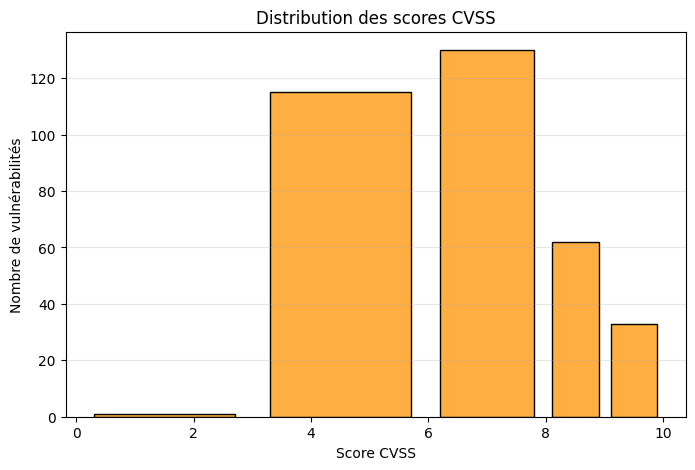

In [159]:

plt.figure(figsize=(8,5))
plt.hist(df["Score CVSS"].dropna(), bins=[0,3,6,8,9,10], color="#ffae42", edgecolor="black", rwidth=0.8)
plt.title("Distribution des scores CVSS")
plt.xlabel("Score CVSS")
plt.ylabel("Nombre de vulnérabilités")
plt.grid(axis='y', alpha=0.3)
plt.show()


### Pie chart des principales catégories CWE

Ce diagramme  illustre la répartition des 7 catégories CWE les plus fréquentes, en excluant les cas non renseignés ("Non disponible").

Chaque segment représente un type de faiblesse identifié dans les vulnérabilités du jeu de données



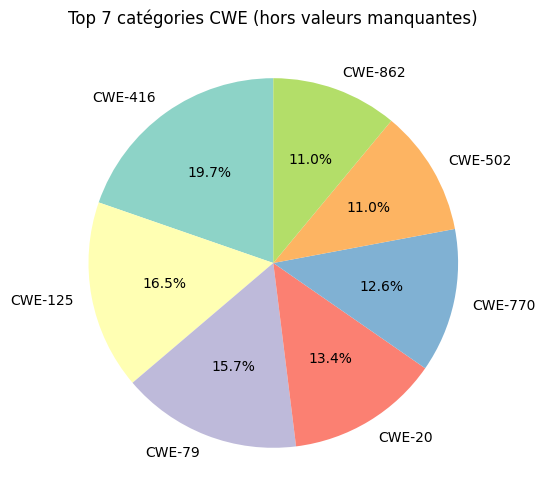

In [160]:

cwe_counts = df[df["Type CWE"] != "Non disponible"]["Type CWE"].value_counts().head(7)
plt.figure(figsize=(6,6))
cwe_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3"))
plt.title("Top 7 catégories CWE (hors valeurs manquantes)")
plt.ylabel("")
plt.show()


### Scatter CVSS/EPSS

Ce nuage de points met en relation deux indicateurs clés de sécurité :
- CVSS : mesure la gravité d’une vulnérabilité (axe des abscisses),
- EPSS : estime la probabilité qu’une vulnérabilité soit exploitée activement (axe des ordonnées).

Chaque point représente une vulnérabilité unique. 
La couleur des points reflète la gravité CVSS


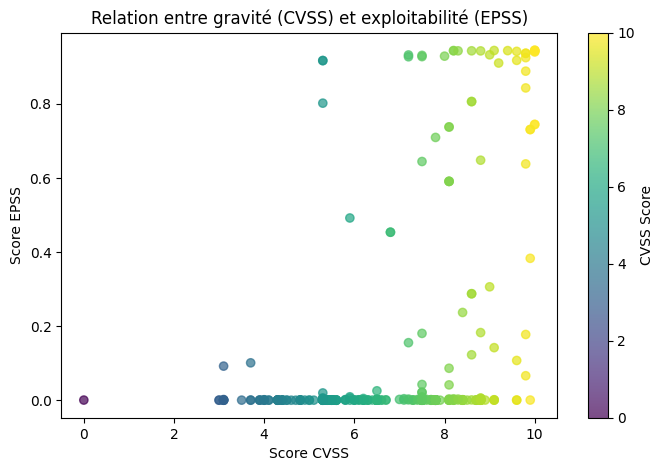

In [161]:
plt.figure(figsize=(8,5))
plt.scatter(df["Score CVSS"], df["Score EPSS"], c=df["Score CVSS"], cmap='viridis', alpha=0.7)
plt.colorbar(label='CVSS Score')
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.title("Relation entre gravité (CVSS) et exploitabilité (EPSS)")
plt.show()


### Top éditeurs les plus vulnérables 

Ce graphique en barres horizontales présente les 10 éditeurs ou fournisseurs de logiciels comptant le plus grand nombre de vulnérabilités répertoriées dans le jeu de données.



C:\Users\gabri\AppData\Local\Temp\ipykernel_3448\578243467.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_editeurs_df, x="Nombre de vulnérabilités", y="\u00c9diteur", palette="viridis")


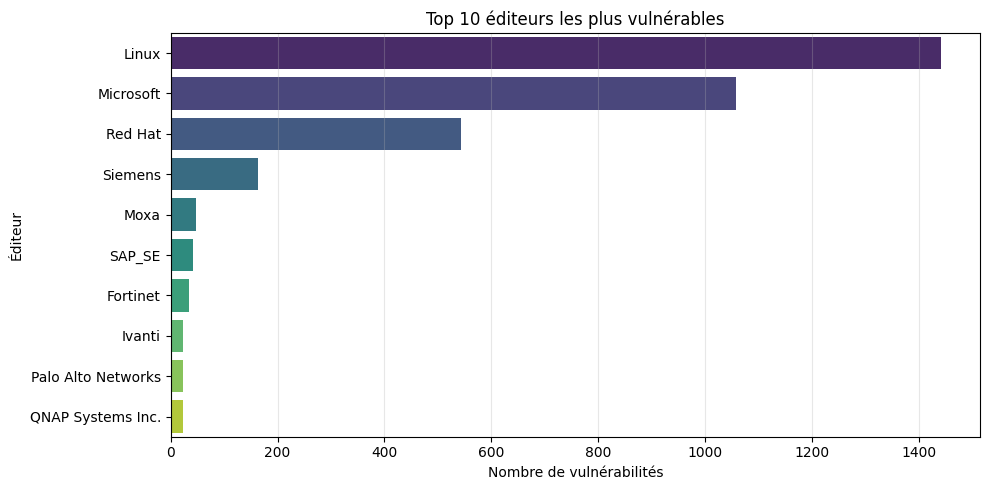

In [162]:

editeurs = df["\u00c9diteur/Vendor"].dropna().astype(str).tolist()
editeurs_nettoyes = [e.strip() for line in editeurs for e in line.split(",") if e.strip().lower() != "non disponible"]
compte_editeurs = Counter(editeurs_nettoyes)
top_editeurs_df = pd.DataFrame(compte_editeurs.most_common(10), columns=["\u00c9diteur", "Nombre de vulnérabilités"])
plt.figure(figsize=(10,5))
sns.barplot(data=top_editeurs_df, x="Nombre de vulnérabilités", y="\u00c9diteur", palette="viridis")
plt.title("Top 10 éditeurs les plus vulnérables")
plt.xlabel("Nombre de vulnérabilités")
plt.ylabel("Éditeur")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


### Evolution temporelle mensuelle

Ce graphique linéaire représente l’évolution mensuelle du nombre de vulnérabilités publiées, en se basant sur la colonne "Date de publication" du jeu de données.

Chaque point indique le nombre de vulnérabilités publiées durant un mois donné

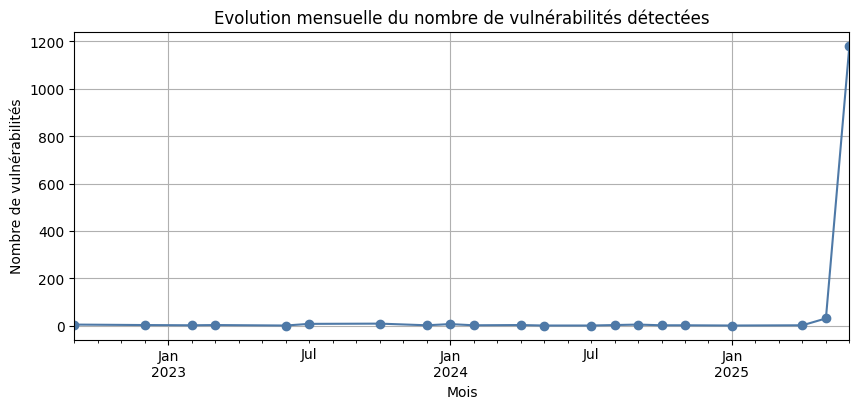

In [163]:

df["Date de publication"] = pd.to_datetime(df["Date de publication"], errors="coerce")
vul_per_month = df.groupby(df["Date de publication"].dt.to_period("M")).size()
vul_per_month.plot(kind="line", marker='o', figsize=(10,4), color="#4e79a7")
plt.title("Evolution mensuelle du nombre de vulnérabilités détectées")
plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.grid()
plt.show()


### Heatmap CVSS/EPSS

Cette carte thermique (heatmap) affiche la corrélation statistique entre deux variables clés du jeu de données :
- CVSS: mesure de la gravité d'une vulnérabilité,
- EPSS: probabilité estimée qu'une vulnérabilité soit exploitée.
- Proche de 1 : forte corrélation positive 
- Proche de 0 : absence de lien linéaire,
- Proche de –1 : corrélation négative 



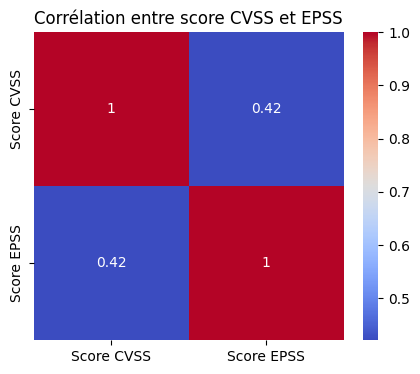

In [164]:
plt.figure(figsize=(5,4))
sns.heatmap(df[["Score CVSS", "Score EPSS"]].corr(), annot=True, cmap="coolwarm")
plt.title("Corrélation entre score CVSS et EPSS")
plt.show()


###  Boxplot des scores CVSS par éditeur 

Ce boxplot permet de visualiser la distribution des scores CVSS pour les 5 éditeurs les plus représentés dans le jeu de données.

Chaque boîte représente :
- La médiane (trait horizontal dans la boîte),
- Les quartiles (limites inférieure et supérieure de la boîte),
- Les valeurs extrêmes*(moustaches),
- Éventuellement des outliers (points isolés).


C:\Users\gabri\AppData\Local\Temp\ipykernel_3448\1678901747.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top5, x="\u00c9diteur", y="Score CVSS", palette="Set2")


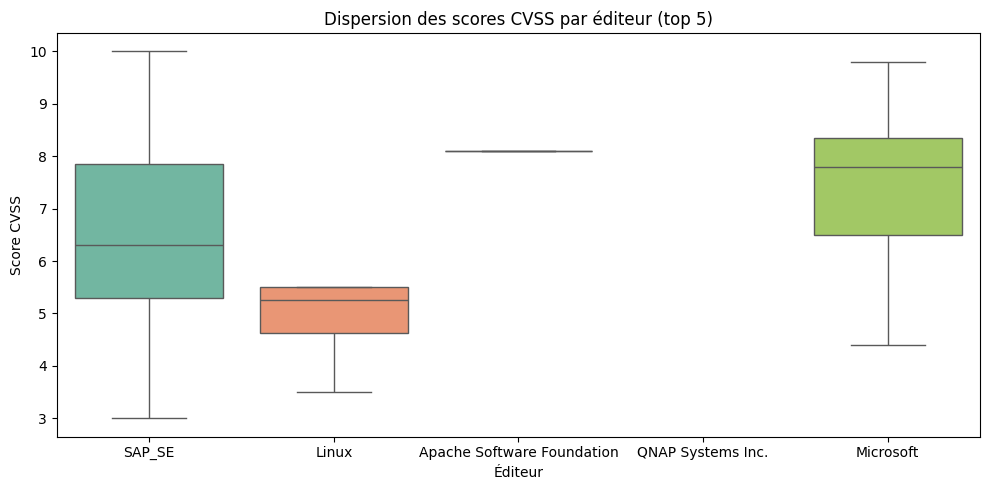

In [165]:

df_editeurs = df[df["\u00c9diteur/Vendor"].notna() & (df["\u00c9diteur/Vendor"].str.lower() != "non disponible")].copy()
df_editeurs["\u00c9diteur"] = df_editeurs["\u00c9diteur/Vendor"].astype(str).str.split(",").str[0].str.strip()
top5 = df_editeurs["\u00c9diteur"].value_counts().head(5).index
df_top5 = df_editeurs[df_editeurs["\u00c9diteur"].isin(top5)]
plt.figure(figsize=(10,5))
sns.boxplot(data=df_top5, x="\u00c9diteur", y="Score CVSS", palette="Set2")
plt.title("Dispersion des scores CVSS par éditeur (top 5)")
plt.xlabel("Éditeur")
plt.ylabel("Score CVSS")
plt.tight_layout()
plt.show()


###  Histogramme des scores EPSS

Cet histogramme présente la distribution des scores EPSS.
Ce graphique permet :
- D’évaluer si les vulnérabilités sont globalement peu ou très exploitables,
- D’identifier la proportion de vulnérabilités à haut risque d’exploitation,
- De prioriser les mesures de correction en fonction de leur niveau de menace immédiate.



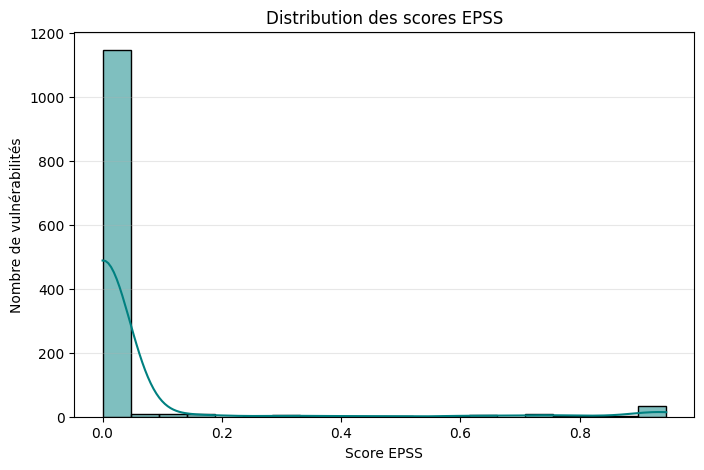

In [166]:

plt.figure(figsize=(8,5))
sns.histplot(df["Score EPSS"].dropna(), bins=20, kde=True, color="teal")
plt.title("Distribution des scores EPSS")
plt.xlabel("Score EPSS")
plt.ylabel("Nombre de vulnérabilités")
plt.grid(axis='y', alpha=0.3)
plt.show()


### Analyse des versions les plus affectées 

Ce graphique en barres met en évidence les 10 versions logicielles les plus fréquemment mentionnées dans les données de vulnérabilités

Chaque barre représente le nombre de vulnérabilités associées à une version spécifique


C:\Users\gabri\AppData\Local\Temp\ipykernel_3448\1705129851.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_versions.values, y=top_versions.index, palette="mako")


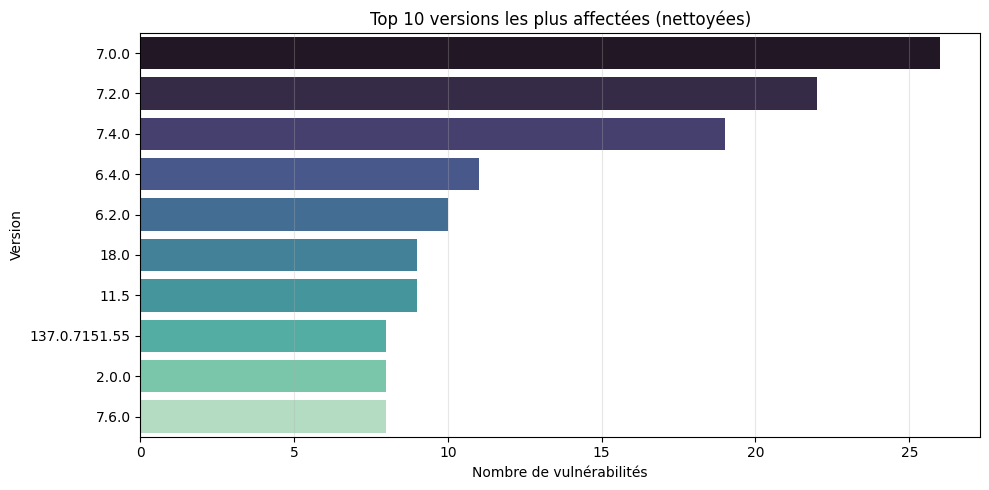

In [167]:

# 12. 
versions = df["Versions affectées"].dropna().astype(str)
versions = versions[~versions.str.lower().str.contains("non disponible")]
liste_versions = []
for ligne in versions:
    for version in ligne.split(","):
        v = version.strip()
        if re.match(r"^\d+(\.\d+){1,3}$", v):
            liste_versions.append(v)
top_versions = pd.Series(liste_versions).value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_versions.values, y=top_versions.index, palette="mako")
plt.title("Top 10 versions les plus affectées (nettoyées)")
plt.xlabel("Nombre de vulnérabilités")
plt.ylabel("Version")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


### Répartition des bulletins par éditeur

Ce graphique en barres groupées présente la répartition des types des avis et alertes publiés pour les 10 éditeurs les plus affectés.

Chaque barre indique le nombre de bulletins publiés pour un éditeur donné



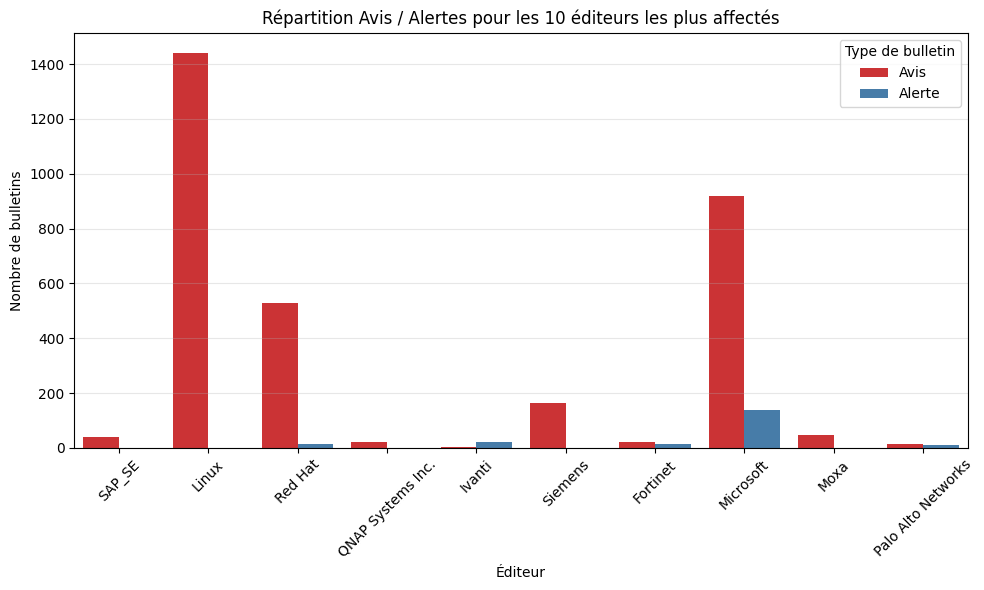

In [168]:

editeurs_raw = df["Éditeur/Vendor"].dropna().astype(str)
editeurs_clean = [e.strip() for ligne in editeurs_raw for e in ligne.split(",") if e.strip().lower() != "non disponible"]

top10_editeurs = [e for e, _ in Counter(editeurs_clean).most_common(10)]

df_temp = df.copy()
df_temp["Éditeurs_individuels"] = df_temp["Éditeur/Vendor"].dropna().astype(str).apply(
    lambda x: [e.strip() for e in x.split(",") if e.strip().lower() != "non disponible"])
df_exploded = df_temp.explode("Éditeurs_individuels")
df_exploded = df_exploded[df_exploded["Éditeurs_individuels"].isin(top10_editeurs)]

plt.figure(figsize=(10,6))
sns.countplot(data=df_exploded, x="Éditeurs_individuels", hue="Type de bulletin", palette="Set1")
plt.title("Répartition Avis / Alertes pour les 10 éditeurs les plus affectés")
plt.xlabel("Éditeur")
plt.ylabel("Nombre de bulletins")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### Produits les plus vulnérables

Ce graphique en barres horizontales met en évidence les 10 produits logiciels pour lesquels le plus grand nombre de vulnérabilités ont été identifiées.



C:\Users\gabri\AppData\Local\Temp\ipykernel_3448\2092931374.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_produits_df, x="Nombre de vulnérabilités", y="Produit", palette="rocket")


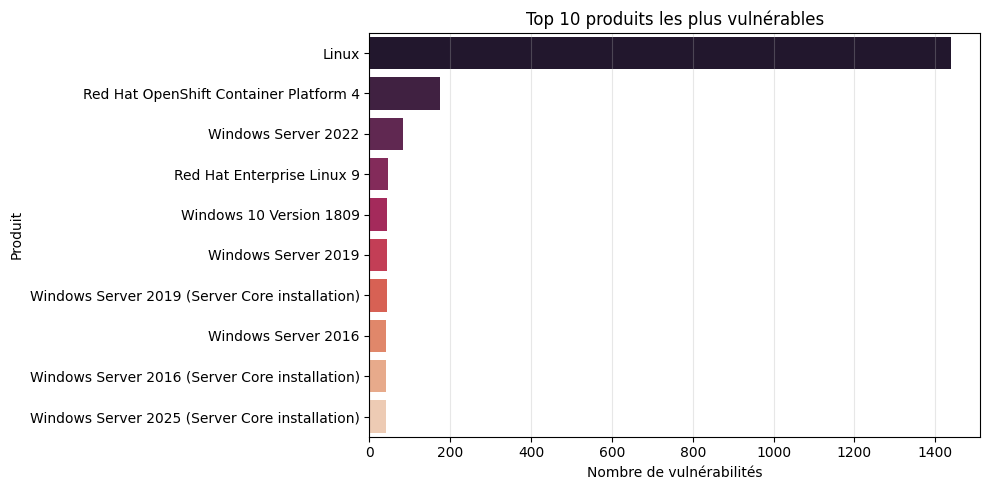

In [169]:

# 14. 
produits = df["Produit"].dropna().astype(str)
produits = produits[~produits.str.lower().str.contains("non disponible")]
liste_produits = [p.strip() for ligne in produits for p in ligne.split(",") if p.strip()]
compte_produits = Counter(liste_produits)
top_produits_df = pd.DataFrame(compte_produits.most_common(10), columns=["Produit", "Nombre de vulnérabilités"])
plt.figure(figsize=(10,5))
sns.barplot(data=top_produits_df, x="Nombre de vulnérabilités", y="Produit", palette="rocket")
plt.title("Top 10 produits les plus vulnérables")
plt.xlabel("Nombre de vulnérabilités")
plt.ylabel("Produit")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


### Types de bulletins 

Ce graphique en barres horizontales présente les bulletins.


C:\Users\gabri\AppData\Local\Temp\ipykernel_3448\2607418998.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bulletin_counts.values, y=bulletin_counts.index, palette="Blues_d")


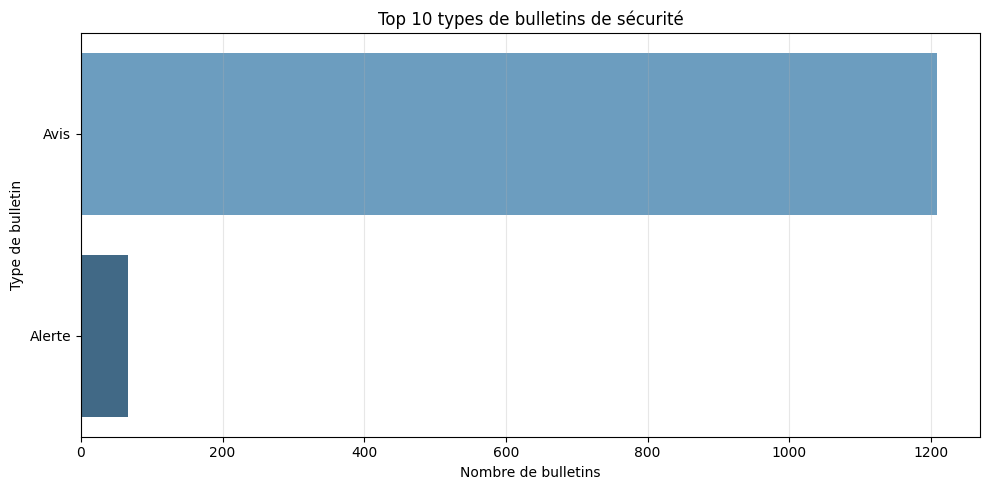

In [170]:

# 15. 
df_bulletin = df[df["Type de bulletin"].notna() & (df["Type de bulletin"].str.lower() != "non disponible")]
bulletin_counts = df_bulletin["Type de bulletin"].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=bulletin_counts.values, y=bulletin_counts.index, palette="Blues_d")
plt.title("Top 10 types de bulletins de sécurité")
plt.xlabel("Nombre de bulletins")
plt.ylabel("Type de bulletin")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


### Types de CWE 

Ce graphique présente les 10 types de vulnérabilités logicielles les plus couramment identifiés dans le jeu de données.


C:\Users\gabri\AppData\Local\Temp\ipykernel_3448\378847743.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cwe_counts.values, y=cwe_counts.index, palette="magma")


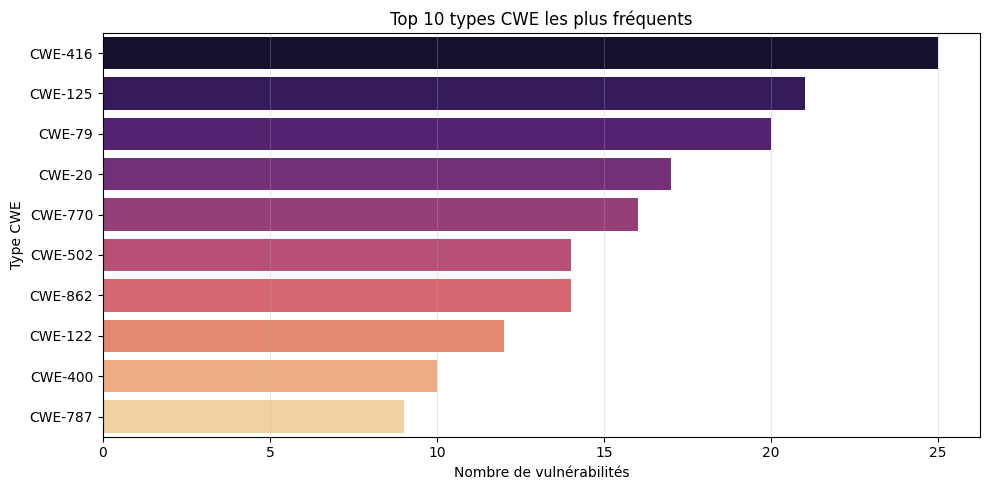

In [171]:

# 16. 
df_cwe = df[df["Type CWE"].notna() & (df["Type CWE"] != "Non disponible")]
cwe_counts = df_cwe["Type CWE"].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=cwe_counts.values, y=cwe_counts.index, palette="magma")
plt.title("Top 10 types CWE les plus fréquents")
plt.xlabel("Nombre de vulnérabilités")
plt.ylabel("Type CWE")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


# **Machine Learning**

In [172]:
df_ml = df.dropna(subset=["Score CVSS", "Score EPSS", "Base Severity"])
df_ml = df_ml[df_ml["Base Severity"].isin(["Critique", "Élevée", "Moyenne", "Faible"])]

X = df_ml[["Score CVSS", "Score EPSS"]].copy()
y = df_ml["Base Severity"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Clustering non supervisé : KMeans

Il nous permet d'identifier des groupes de vulnérabilités similaires sans avoir besoin de labels préexistants.

On utilise la méthode du coude pour conaitre le nombre optimale de cluster


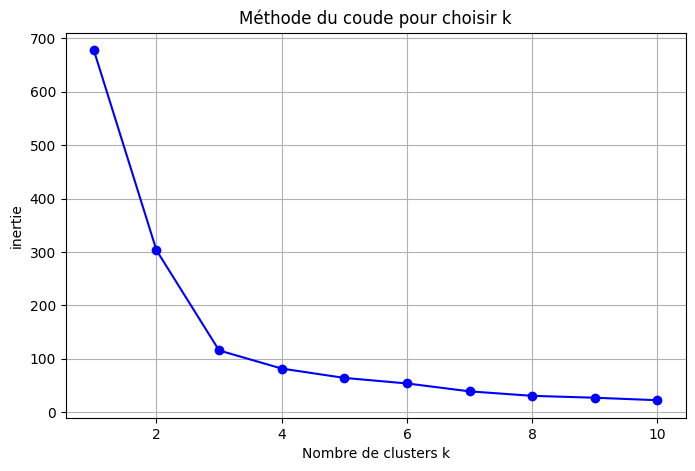

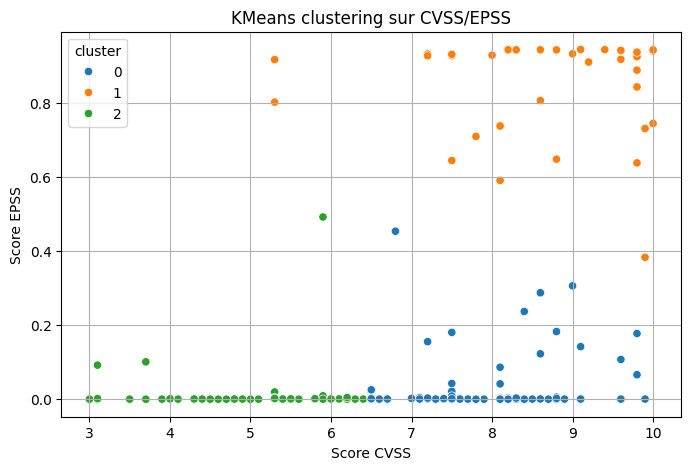

In [173]:
inertias = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertias, 'bo-')
plt.xlabel('Nombre de clusters k')
plt.ylabel('inertie')
plt.title("Méthode du coude pour choisir k")
plt.grid()
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
df_ml["cluster"] = kmeans.fit_predict(X_scaled)
plt.figure(figsize=(8,5))
sns.scatterplot(x=X["Score CVSS"], y=X["Score EPSS"], hue=df_ml["cluster"], palette="tab10")
plt.title("KMeans clustering sur CVSS/EPSS")
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.grid()
plt.show()

##  Modèle supervisé : KNN 

Pour la classification supervisée, on utilise l’algorithme KNN , qui classe une observation en fonction des `k` observations les plus proches dans l’espace des variables.


Classification avec KNN :

              precision    recall  f1-score   support

    Critique       1.00      1.00      1.00         9
      Faible       1.00      0.67      0.80         3
     Moyenne       0.97      0.92      0.94        36
      Élevée       0.95      1.00      0.97        54

    accuracy                           0.96       102
   macro avg       0.98      0.90      0.93       102
weighted avg       0.96      0.96      0.96       102



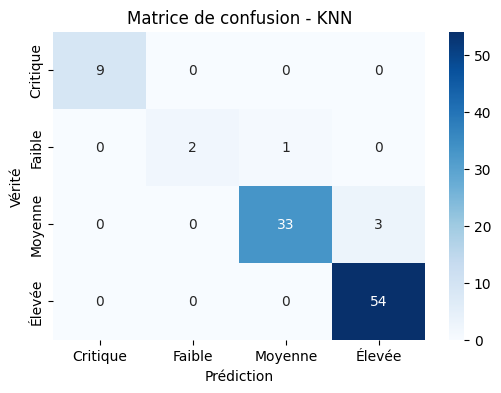

In [174]:

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Classification avec KNN :\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Prédiction")
plt.ylabel("Vérité")
plt.title("Matrice de confusion - KNN")
plt.show()